In [ ]:
!pip install -q --upgrade pip
!pip install -q gdown
!gdown --id 1PVuP_gOIzdQGUsbPknBxnMESgH_jw0b7

In [ ]:
!pip install -q tf_keras

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tf_keras as keras
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from sklearn.utils import resample
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix,classification_report
import re

2024-04-09 03:39:52.610825: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-09 03:39:52.610876: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-09 03:39:52.612329: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# Step 1: Load the dataset
data = pd.read_pickle("/kaggle/working/review_CDs_and_Vinyl") 
data.shape

(1097592, 9)

In [4]:
review_counts = data['asin'].value_counts()

# Step 2: Sort the items based on the number of reviews in descending order
top_items = review_counts.sort_values(ascending=False).index[:5000]

# Step 3: Select the first 5000 items from the sorted list
top_items_data = data[data['asin'].isin(top_items)]

In [5]:
data = top_items_data[['reviewText','overall']]
data.shape

(429294, 2)

In [6]:
df_5 = data[data['overall']==5]
df_4 = data[data['overall']==4]
df_3 = data[data['overall']==3]
df_2 = data[data['overall']==2]
df_1 = data[data['overall']==1]

df = pd.concat([df_1.sample(20296),df_2.sample(20296),df_3.sample(20296),df_4.sample(20296),df_5.sample(20296)])
df['reviewText'] = df['reviewText'].apply(lambda x:x.lower())
df['overall'].value_counts()


overall
1.0    20296
2.0    20296
3.0    20296
4.0    20296
5.0    20296
Name: count, dtype: int64

In [7]:
# removing special chars
df['reviewText'] = df['reviewText'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))
#
df.head()

# Step 2: Preprocess the text data
X = df['reviewText'].values
y = df['overall'].values

In [8]:
max_fatures = 2000
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(df['reviewText'].values)
X = tokenizer.texts_to_sequences(df['reviewText'].values)
X = pad_sequences(X)
X[:2]

array([[   0,    0,    0, ...,  608,    2,  998],
       [   0,    0,    0, ...,   17,    5, 1540]], dtype=int32)

In [9]:
from sklearn.preprocessing import LabelEncoder
y = df['overall']
y = pd.get_dummies(y,dtype=int)
y.sample()

,1.0,2.0,3.0,4.0,5.0
208027,0,0,0,0,1


In [10]:
embed_dim = 128
lstm_out = 128

model = Sequential()
model.add(Embedding(max_fatures, embed_dim,input_length = X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(5,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 2632, 128)         256000    
                                                                 
 spatial_dropout1d (Spatial  (None, 2632, 128)         0         
 Dropout1D)                                                      
                                                                 
 lstm (LSTM)                 (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 5)                 645       
                                                                 
Total params: 388229 (1.48 MB)
Trainable params: 388229 (1.48 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [11]:
Y = pd.get_dummies(df['overall']).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.20, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(81184, 2632) (81184, 5)
(20296, 2632) (20296, 5)


In [12]:
batch_size = 256
model.fit(X_train, Y_train, epochs = 3, batch_size=batch_size, verbose = 1)

Epoch 1/3


I0000 00:00:1712634046.015042     457 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


318/318 [==============================] - 2136s 7s/step - loss: 1.3030 - accuracy: 0.4324
Epoch 2/3
318/318 [==============================] - 2147s 7s/step - loss: 1.1519 - accuracy: 0.5107
Epoch 3/3
318/318 [==============================] - 2178s 7s/step - loss: 1.1271 - accuracy: 0.5224


In [22]:
# Evaluate the model
y_pred = model.predict(X_test)

635/635 [==============================] - 337s 531ms/step


In [24]:
pred = np.argmax(y_pred,axis=1) + 1
pred

array([1, 1, 5, ..., 3, 3, 2])

In [32]:
y_test = pd.DataFrame(Y_test).idxmax(axis=1) + 1
y_test

0        1
1        1
2        5
3        1
4        4
        ..
20291    4
20292    3
20293    1
20294    2
20295    1
Length: 20296, dtype: int64

In [34]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           1       0.64      0.70      0.67      4063
           2       0.46      0.32      0.38      4057
           3       0.43      0.41      0.42      4109
           4       0.42      0.46      0.44      4088
           5       0.58      0.68      0.62      3979

    accuracy                           0.51     20296
   macro avg       0.51      0.51      0.51     20296
weighted avg       0.51      0.51      0.51     20296



In [36]:
print(confusion_matrix(y_test, pred))

[[2833  677  266  110  177]
 [ 965 1294 1168  420  210]
 [ 250  599 1694 1227  339]
 [ 158  167  617 1868 1278]
 [ 244   80  158  779 2718]]


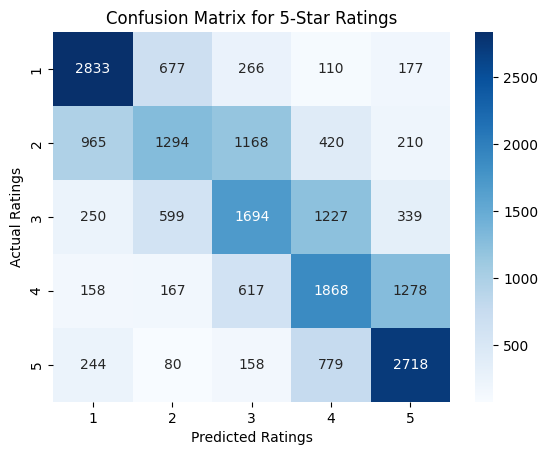

In [40]:
import seaborn as sns
from matplotlib import pyplot as plt
conf_matrix = confusion_matrix(y_test, pred, labels=[1, 2, 3, 4, 5])

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[1, 2, 3, 4, 5], yticklabels=[1, 2, 3, 4, 5])
plt.xlabel('Predicted Ratings')
plt.ylabel('Actual Ratings')
plt.title('Confusion Matrix for 5-Star Ratings')
plt.show()